## Calculate temperature profiles under different modelling assumptions

In [1]:
# Set directory
ROOT_DIR = abspath(joinpath(pwd(),"../../"))
if !haskey(ENV, "RAD_DIR")
    ENV["RAD_DIR"] = joinpath(ROOT_DIR,"socrates")
end
println(ROOT_DIR)

/Users/nichollsh/Projects/AGNI/


In [2]:
# Import system packages
using Pkg
using Printf
using DelimitedFiles
using Plots
default(label=nothing, grid=true)

using LaTeXStrings

In [3]:
# Import AGNI
Pkg.activate(ROOT_DIR)
using AGNI

# Normal logging from AGNI module
AGNI.setup_logging("",1)

  Activating project at `~/Projects/AGNI`


In [4]:
R_earth = 6.371e6 # m
M_earth = 5.972e24 # kg
S_earth = 1361.0 # W/m^2

1361.0

### Define atmosphere parameters

In [5]:
"""
Update interior structure

Returns surface radius [m], surface gravity [m s-2], and surface pressure [bar]
"""
function calc_struct(mtot, fatm, fcor)
    # atmosphere mass [SI units]
    mass_atm = mtot * fatm

    # interior mass from remainder
    interior_mass = mtot - mass_atm

    # get interior radius from fit to Zalmoxis
     # fit coefficients
    m0 =  1.2034502662
    m1 =  0.2638026977
    c0 = -0.2115696893
    c1 =  1.992280927
    e0 = -0.1028476164
    e1 =  0.5909898648
    o1 = -0.1505066123


    # evaluate fit
    m = mtot / M_earth
    Rsurf = (  m0*((1-fatm)*m)^m1 + c0*(fcor/(1-fatm))^c1 + e0*(m*fcor)^e1  + o1  ) * R_earth

    # surface gravity
    gsurf = phys.grav_accel(mtot * (1-fatm), Rsurf)

    # surface pressure
    psurf = 1e-5 * mass_atm * gsurf / (4 * pi * Rsurf^2)

    return (Rsurf, gsurf, psurf)
end

calc_struct

In [27]:
f_atm = 2e-2
f_cor = 0.325
m_tot = 6.3

(radius, gravity, p_surf) = calc_struct(m_tot * M_earth, f_atm, f_cor)

(1.0284214148909738e7, 23.26751084651833, 131731.05875442157)

In [28]:
# Configuration options
instellation    = 42.5 * S_earth # Earth instellation flux
println("S = $instellation W/m^2")

zenith          = 54.74
albedo          = 0.0
s0_fact         = 0.25
nlev_centre     = 45
t_surf          = 2300.0   # approx solidus at 10 GPa
p_top           = 1e-3      # bar

println("Rs = $(radius/R_earth)")


Z = 10^(-1.0) # metallicity
xH2O = 2 * (1.0 / 16.0) * Z  # calc xH2O from metallicity, assuming H2O+H2 only
mole_fractions  = Dict([ ("H2O", xH2O), ("H2", 1-xH2O)])
println(mole_fractions)

spectral_file = joinpath(ROOT_DIR,"res/spectral_files/Dayspring/48/Dayspring.sf")

# Create output directory
output_dir = joinpath(ROOT_DIR,"out")
rm(output_dir,force=true,recursive=true)
mkdir(output_dir)
println(output_dir)

S = 57842.5 W/m^2
Rs = 1.6142229083204738
Dict("H2O" => 0.0125, "H2" => 0.9875)
/Users/nichollsh/Projects/AGNI/out


### Initialise the atmosphere

In [29]:
# Setup atmosphere
atmos = atmosphere.Atmos_t()
atmosphere.setup!(atmos, ROOT_DIR, output_dir,
                        spectral_file,
                        instellation, s0_fact, albedo, zenith,
                        t_surf,
                        gravity, radius,
                        nlev_centre, p_surf, p_top,
                        mole_fractions, "",
                        flag_gcontinuum=true,
                        flag_rayleigh=true,
                        thermo_functions=true,
                        real_gas=true
                        )
atmosphere.allocate!(atmos, "blackbody"; stellar_Teff=5484.0)
setpt.isothermal!(atmos, atmos.tmp_surf)
println("Done!")

[ INFO  ] Setting-up a new atmosphere struct
[ INFO  ] Loading thermodynamic data
[ WARN  ] Surface pressure exceeds the valid range (H2O EOS)
[ WARN  ] Surface pressure exceeds the valid range (H2 EOS)
[ INFO  ] Inserting stellar spectrum and Rayleigh coefficients
[ INFO  ] Allocating atmosphere with initial composition:
[ INFO  ]       1 H2O     1.25e-02 (EOS_AQUA)
[ INFO  ]       2 H2      9.88e-01 (EOS_CMS19)
Done!


## Run the model under various scenarios

In [30]:
sol_type = 1

atmos.tmp_surf = deepcopy(t_surf)

for (g,x) in mole_fractions
    fill!(atmos.gas_ovmr[g], x)
    fill!(atmos.gas_vmr[g],  x)
    println("Gas $g = $(atmos.gas_ovmr[g][end])")
end

atmos_results::Dict{String, atmosphere.Atmos_t} = Dict{String, atmosphere.Atmos_t}()

Gas H2O = 0.0125
Gas H2 = 0.9875


Dict{String, AGNI.atmosphere.Atmos_t}()

In [31]:
atmosphere.HYDROGRAV_constg   = true     # constant gravity with height?
atmosphere.HYDROGRAV_selfg    = false     # include self-gravity of the atmosphere?
atmosphere.HYDROGRAV_steps    = 10000    # number of levels for hydrostatic integration
atmosphere.HYDROGRAV_maxdr    = 1e9      # max dr across each level
atmosphere.HYDROGRAV_ming     = 1e-30   # min gravity

println(atmosphere.HYDROGRAV_constg)
println(atmosphere.HYDROGRAV_selfg)
println(atmosphere.HYDROGRAV_steps)
println(atmosphere.HYDROGRAV_maxdr)
println(atmosphere.HYDROGRAV_ming)

true
false
10000
1.0e9
1.0e-30


In [32]:
# Isothermal, constant gravity
atmosphere.HYDROGRAV_selfg    = false
atmosphere.HYDROGRAV_constg   = true

succ = solver.solve_prescribed!(atmos, sol_type=sol_type, atm_type=1, tmp_upper=2000.0)
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)

atmos_results["cg_Iso"] = deepcopy(atmos)
println("Rphot = $(atmos.transspec_r/R_earth)")
all(isfinite.(atmos.flux_n))

[ INFO  ]     total flux         = +1.58e+06 W m-2     
[ INFO  ]     surf temperature   = 2300.000  K        
[ INFO  ]     surf pressure      = 1.3e+05 bar      
Solver success? true
Rphot = 2.888063503506801


true

In [33]:
# Isothermal, r2 gravity
atmosphere.HYDROGRAV_selfg    = false
atmosphere.HYDROGRAV_constg   = false

succ = solver.solve_prescribed!(atmos, sol_type=sol_type, atm_type=1, tmp_upper=2000.0)
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)

atmos_results["r2_Iso"] = deepcopy(atmos)
println("Rphot = $(atmos.transspec_r/R_earth)")
all(isfinite.(atmos.flux_n))

[ INFO  ]     total flux         = +1.58e+06 W m-2     
[ INFO  ]     surf temperature   = 2300.000  K        
[ INFO  ]     surf pressure      = 1.3e+05 bar      
Solver success? true
Rphot = 7.652392194734869


true

In [34]:
# Isothermal, self gravity
atmosphere.HYDROGRAV_selfg    = true
atmosphere.HYDROGRAV_constg   = false

succ = solver.solve_prescribed!(atmos, sol_type=sol_type, atm_type=1, tmp_upper=2000.0)
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)

atmos_results["sg_Iso"] = deepcopy(atmos)
println("Rphot = $(atmos.transspec_r/R_earth)")
all(isfinite.(atmos.flux_n))

[ INFO  ]     total flux         = +1.58e+06 W m-2     
[ INFO  ]     surf temperature   = 2300.000  K        
[ INFO  ]     surf pressure      = 1.3e+05 bar      
Solver success? true
Rphot = 6.884616552457077


true

In [35]:
# Adiabatic, const gravity
atmosphere.HYDROGRAV_selfg    = false
atmosphere.HYDROGRAV_constg   = !atmosphere.HYDROGRAV_selfg

succ = solver.solve_prescribed!(atmos, sol_type=sol_type, atm_type=2, tmp_upper=30000.0)
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)

atmos_results["cg_Ad"] = deepcopy(atmos)
println("Rphot = $(atmos.transspec_r/R_earth)")
all(isfinite.(atmos.flux_n))

[ INFO  ]     total flux         = -6.62e+03 W m-2     
[ INFO  ]     surf temperature   = 2300.000  K        
[ INFO  ]     surf pressure      = 1.3e+05 bar      
Solver success? true
Rphot = 2.019028916943738


true

In [36]:
# Adiabatic, r2 gravity
atmosphere.HYDROGRAV_selfg    = false
atmosphere.HYDROGRAV_constg   = false

succ = solver.solve_prescribed!(atmos, sol_type=sol_type, atm_type=2, tmp_upper=30000.0)
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)

atmos_results["r2_Ad"] = deepcopy(atmos)
println("Rphot = $(atmos.transspec_r/R_earth)")
all(isfinite.(atmos.flux_n))

[ INFO  ]     total flux         = -6.59e+03 W m-2     
[ INFO  ]     surf temperature   = 2300.000  K        
[ INFO  ]     surf pressure      = 1.3e+05 bar      
Solver success? true
Rphot = 2.154467217230245


true

In [37]:
# Adiabatic, self gravity
atmosphere.HYDROGRAV_selfg    = true
atmosphere.HYDROGRAV_constg   = false

succ = solver.solve_prescribed!(atmos, sol_type=sol_type, atm_type=2, tmp_upper=20000.0)
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)

atmos_results["sg_Ad"] = deepcopy(atmos)
println("Rphot = $(atmos.transspec_r/R_earth)")
all(isfinite.(atmos.flux_n))

[ INFO  ]     total flux         = -6.60e+03 W m-2     
[ INFO  ]     surf temperature   = 2300.000  K        
[ INFO  ]     surf pressure      = 1.3e+05 bar      
Solver success? true
Rphot = 2.142611987824007


true

In [38]:
# Adiabatic + stratosphere, const gravity
atmosphere.HYDROGRAV_selfg    = false
atmosphere.HYDROGRAV_constg   = !atmosphere.HYDROGRAV_selfg

succ = solver.solve_prescribed!(atmos, sol_type=sol_type, atm_type=3, tmp_upper=50000.0)
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)

atmos_results["cg_AdS"] = deepcopy(atmos)
println("Rphot = $(atmos.transspec_r/R_earth)")
all(isfinite.(atmos.flux_n))

[ INFO  ]     total flux         = +6.11e+02 W m-2     
[ INFO  ]     surf temperature   = 2300.000  K        
[ INFO  ]     surf pressure      = 1.3e+05 bar      
Solver success? true
Rphot = 2.207910484007015


true

In [39]:
# Adiabatic + stratosphere, r2 gravity
atmosphere.HYDROGRAV_selfg    = false
atmosphere.HYDROGRAV_constg   = false

succ = solver.solve_prescribed!(atmos, sol_type=sol_type, atm_type=3, tmp_upper=50000.0)
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)

atmos_results["r2_AdS"] = deepcopy(atmos)
println("Rphot = $(atmos.transspec_r/R_earth)")
all(isfinite.(atmos.flux_n))

[ INFO  ]     total flux         = +5.88e+02 W m-2     
[ INFO  ]     surf temperature   = 2300.000  K        
[ INFO  ]     surf pressure      = 1.3e+05 bar      
Solver success? true
Rphot = 2.5531875009768457


true

In [40]:
# Adiabatic + stratosphere, self gravity
atmosphere.HYDROGRAV_selfg    = true
atmosphere.HYDROGRAV_constg   = !atmosphere.HYDROGRAV_selfg

succ = solver.solve_prescribed!(atmos, sol_type=sol_type, atm_type=3, tmp_upper=50000.0)
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)

atmos_results["sg_AdS"] = deepcopy(atmos)
println("Rphot = $(atmos.transspec_r/R_earth)")
all(isfinite.(atmos.flux_n))

[ INFO  ]     total flux         = +5.87e+02 W m-2     
[ INFO  ]     surf temperature   = 2300.000  K        
[ INFO  ]     surf pressure      = 1.3e+05 bar      
Solver success? true
Rphot = 2.5220130557433644


true

In [41]:
# Radiative-convective, const gravity
atmosphere.HYDROGRAV_selfg    = false
atmosphere.HYDROGRAV_constg   = true

setpt.loglinear!(atmos, 500.0) # initial guess
succ = solver.solve_energy!(atmos,
                                    sol_type=sol_type,
                                    method=1,
                                    dx_max=200.0,
                                    ls_method=2,
                                    modplot=1,
                                    save_frames=false,
                                    detect_plateau=true,
                                    conv_atol=1.0
                                    )
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)

atmos_results["cg_RCE"] = deepcopy(atmos)
println("Rphot = $(atmos.transspec_r/R_earth)")
all(isfinite.(atmos.flux_n))

[ INFO  ]     sol_type  = 1
[ INFO  ]     tmp_surf  = 2300.00 K
[ INFO  ]     step  resid_med    cost     flux_OLR    max(x)    max(|dx|)   flags
[ INFO  ]        1  -2.53e+00  5.936e+04  3.022e+04  2.300e+03  2.000e-03  Cs-C2-Ls
[ INFO  ]        2  -1.09e+00  1.336e+04  1.537e+04  2.300e+03  2.000e+02  Cs-C2
[ INFO  ]        3  -5.92e-01  6.749e+03  1.148e+04  2.300e+03  6.947e+01  Cs-C2-Ls
[ INFO  ]        4  -2.41e-01  3.409e+03  9.322e+03  2.300e+03  5.402e+01  Cs-C2-Ls
[ INFO  ]        5  -1.13e-01  1.722e+03  8.090e+03  2.300e+03  4.085e+01  Cs-C2-Ls
[ INFO  ]        6  -5.07e-02  8.695e+02  7.402e+03  2.300e+03  2.724e+01  Cs-C2-Ls
[ INFO  ]        7  -3.36e-02  4.391e+02  7.033e+03  2.300e+03  1.812e+01  Cs-C2-Ls
[ INFO  ]        8  -1.36e-02  1.221e+04  6.834e+03  2.300e+03  1.122e+01  Cs-C2-Ls
[ INFO  ]        9  +1.54e-05  1.833e+03  6.629e+03  2.300e+03  1.277e+01  Cs-C2
[ INFO  ]       10  +1.09e-07  3.516e+02  6.624e+03  2.300e+03  7.287e-01  Cs-C2
[ INFO  ]       11  +3.

true

In [42]:
# Radiative-convective, r2 gravity
atmosphere.HYDROGRAV_selfg    = false
atmosphere.HYDROGRAV_constg   = false

succ = solver.solve_energy!(atmos,
                                    sol_type=sol_type,
                                    method=1,
                                    dx_max=200.0,
                                    ls_method=2,
                                    modplot=1,
                                    save_frames=false,
                                    detect_plateau=true,
                                    conv_atol=1.0
                                    )
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)

atmos_results["r2_RCE"] = deepcopy(atmos)
println("Rphot = $(atmos.transspec_r/R_earth)")
all(isfinite.(atmos.flux_n))

[ INFO  ]     sol_type  = 1
[ INFO  ]     tmp_surf  = 2300.00 K
[ INFO  ]     step  resid_med    cost     flux_OLR    max(x)    max(|dx|)   flags
[ INFO  ]        1  +4.79e-02  9.983e+04  4.911e+03  2.300e+03  9.900e+01  Cs-C2-Ls
[ INFO  ]        2  +3.77e-02  1.546e+05  5.769e+03  2.300e+03  7.466e+01  Cs-C2-Ls
[ INFO  ]        3  +3.77e-02  1.546e+05  5.769e+03  2.300e+03  7.443e-04  Cs-C2-Ls
[ INFO  ]        4  +3.77e-02  1.546e+05  5.769e+03  2.300e+03  7.443e-04  Cs-C2-Ls
[ INFO  ]        5  +3.77e-02  1.546e+05  5.769e+03  2.300e+03  7.443e-04  Cs-C2-Ls
[ INFO  ]        6  +3.77e-02  1.546e+05  5.769e+03  2.300e+03  7.443e-04  Cs-C2-Ls
[ INFO  ]        7  +3.77e-02  1.546e+05  5.769e+03  2.300e+03  7.443e-04  Cs-C2-Ls
[ INFO  ]        8  -1.29e-01  2.293e+03  1.381e+04  2.300e+03  2.000e+02  Cs-C2-P
[ INFO  ]        9  -9.13e-02  4.728e+02  8.055e+03  2.300e+03  1.871e+02  Cs-C2
[ INFO  ]       10  -1.46e-02  1.051e+02  6.788e+03  2.300e+03  5.850e+01  Cs-C2
[ INFO  ]       11  +

true

In [45]:
# Radiative-convective, self gravity
atmosphere.HYDROGRAV_selfg    = true
atmosphere.HYDROGRAV_constg   = false

succ = solver.solve_energy!(atmos,
                                    sol_type=sol_type,
                                    method=1,
                                    dx_max=350.0,
                                    ls_method=2,
                                    modplot=1,
                                    save_frames=false,
                                    detect_plateau=true,
                                    conv_atol=1.0
                                    )
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)

atmos_results["sg_RCE"] = deepcopy(atmos)
println("Rphot = $(atmos.transspec_r/R_earth)")
all(isfinite.(atmos.flux_n))

[ INFO  ]     sol_type  = 1
[ INFO  ]     tmp_surf  = 2300.00 K
[ INFO  ]     step  resid_med    cost     flux_OLR    max(x)    max(|dx|)   flags
[ INFO  ]        1  -2.57e-03  5.609e+00  6.626e+03  2.300e+03  1.307e+01  Cs-C2-Ls
[ INFO  ]        2  -5.95e-07  1.220e-01  6.617e+03  2.300e+03  5.463e-01  Cs-C2
[ INFO  ]     success in 2 steps
[ INFO  ]     total flux at TOA  = +6.96e-01 W m-2     
[ INFO  ]     total flux at BOA  = +1.05e+00 W m-2     
[ INFO  ]     global flux loss   = +3.98e-01 W m-2  (+3.64e+01 %) 
[ INFO  ]     surf temperature   = 2300.000  K        
[ INFO  ]     surf pressure      = 1.317e+05 bar      
Solver success? true
Rphot = 3.5947829713338666


true

In [46]:
# save to netcdf
for (k,atm) in atmos_results
    save.write_ncdf(atm, joinpath(output_dir,k*".nc"))
end


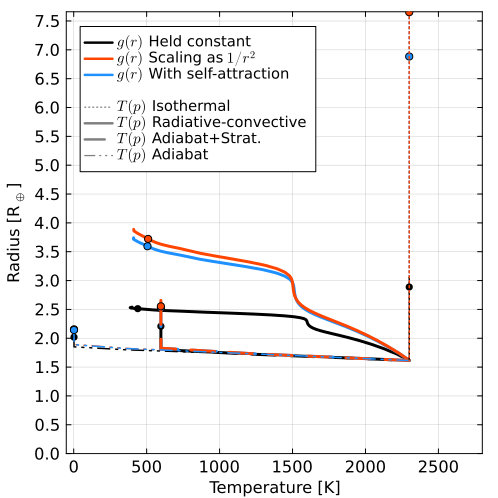

cg_RCE : R=2.5127587362374495
sg_RCE : R=3.5947829713338666
r2_Ad : R=2.154467217230245
r2_RCE : R=3.7213615702757457
sg_Iso : R=6.884616552457077
cg_AdS : R=2.207910484007015
sg_AdS : R=2.5220130557433644
cg_Ad : R=2.019028916943738
r2_AdS : R=2.5531875009768457
sg_Ad : R=2.142611987824007
cg_Iso : R=2.888063503506801
r2_Iso : R=7.652392194734869


In [54]:
fig1 = plot(size=(500,500), frame=:box,
            legend=:topleft, legendcolumns=1, legendfontsize=10,
            ylabel=L"Radius [R$_\oplus$]",
            right_margin = 2Plots.mm, bottom_margin=  -3Plots.mm,
            xlabel="Temperature [K]", labelfontsize=11, tickfontsize=11)

lw0 = 1.5

# Teqm = phys.calc_Tskin(atmos.instellation, atmos.albedo_b)
# vline!(fig1, [Teqm], ls=:dash, color=:palegreen, lw=lw0, label=@sprintf("Skin temperature"))

# default axis limits
y_min = radius/R_earth
y_max = 0.5
x_min = -1
x_max = 10.0

col_sg = "dodgerblue"
col_r2 = "orangered"
col_cg = "black"


lstyles = Dict([("Iso",:dot), ("Ad",:dashdotdot), ("AdS",:dash), ("RCE",:solid)])
lwidths = Dict([("Iso",1),    ("Ad",1),           ("AdS",2),     ("RCE",2)])

# plot
for (k,atm) in atmos_results

    spl = split(k,"_")

    # line label and color
    if spl[1] == "sg"
        col = col_sg
    elseif spl[1] == "cg"
        col = col_cg
    elseif spl[1] == "r2"
        col = col_r2
    end
    ls = lstyles[spl[2]]
    lw = lwidths[spl[2]] * lw0

    # plot profile
    plot!(fig1, atm.tmp, atm.r / R_earth, lw=lw, linestyle=ls, color=col)

    # plot photosphere point
    rtrans = atm.transspec_r/R_earth
    println("$k : R=$rtrans")
    scatter!(fig1, [atm.transspec_tmp], [rtrans], color=col)


    # axis limits
    y_max = max( rtrans, y_max)
    x_max = max( maximum(atm.tmpl), x_max)
end

# legend entries
llw = 2
# scatter!(fig1, [], [], label="Transit radius", color=:grey, markersize=6)
plot!(fig1, [], [], lw=llw, label=L"$g(r)$ Held constant",    lc=col_cg, ls=:solid,  )
plot!(fig1, [], [], lw=llw, label=L"$g(r)$ Scaling as $1/r^2$",       lc=col_r2,  ls=:solid,  )
plot!(fig1, [], [], lw=llw, label=L"$g(r)$ With self-attraction",  lc=col_sg, ls=:solid,  )
plot!(fig1, [], [], label=" ", lc="white") # spacer
plot!(fig1, [], [],         label=L"$T(p)$ Isothermal",          lc="grey",      ls=lstyles["Iso"], lw=lwidths["Iso"]  )
plot!(fig1, [], [],         label=L"$T(p)$ Radiative-convective ",lc="grey",      ls=lstyles["RCE"], lw=lwidths["RCE"]  )
plot!(fig1, [], [],         label=L"$T(p)$ Adiabat+Strat.",      lc="grey",      ls=lstyles["AdS"], lw=lwidths["AdS"]  )
plot!(fig1, [], [],         label=L"$T(p)$ Adiabat",             lc="grey",      ls=lstyles["Ad"], lw=lwidths["Ad"]  )

y_min = round(y_min, RoundDown, digits=1)
y_min = 0.0
y_max = round(y_max, RoundUp, digits=2)
y_tck = 0.5
yaxis!(ylim=(y_min, y_max), yticks=range(y_min, y_max, step=y_tck))
# yaxis!(yscale=:log10)

x_tck = 500.0
x_max = round(x_max+x_tck, RoundUp, digits=0)
xaxis!(xlim=(x_min-50, x_max), xticks=range(0.0, x_max, step=x_tck))
# xaxis!(xscale=:log10)

display(fig1)

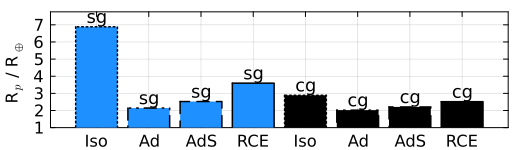

In [48]:
fig2 = plot(legend=:right, size=(520,150),
            ylabel=L"R$_p$ / R$_\oplus$",
            left_margin = 4Plots.mm,
            labelfontsize=11, tickfontsize=11, frame=:box)

# plot
y = Float64[]
x = Float64[]
c = String[]
s = Symbol[]
l = String[]
i = 0
for spl1 in ["sg","cg"]
    for spl2 in ["Iso","Ad","AdS","RCE"]
        i += 1

        # line label and color
        if spl1 == "cg"
            col = col_cg
            ann = "cg"
        elseif spl1 == "sg"
            col = col_sg
            ann = "sg"
        end

        ls = lstyles[spl2]

        k = "$(spl1)_$(spl2)"

        # add photosphere point
        yy = atmos_results[k].transspec_r/R_earth
        push!(y, yy)
        push!(x, i)
        push!(c, col)
        push!(s, ls)
        push!(l, spl2)

        annotate!(fig2, i, yy, (ann,:bottom, 12))
    end
end

bar!(fig2, x, y, linestyle=s, fillcolor=c, linewidth=1.5)

xaxis!(xticks=(x,l))
yaxis!(ylim=(1,y_max+0.1))

display(fig2)

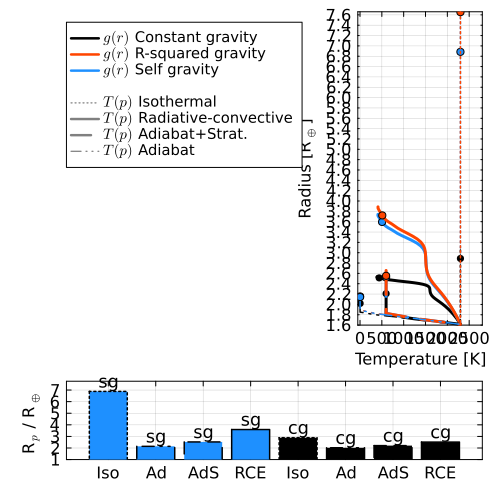

"/Users/nichollsh/Projects/AGNI/out/atmosphere.pdf"

In [49]:
figN = plot(fig1,fig2; layout=grid(2,1, heights=(0.8,0.2)))
display(figN)
savefig(figN, joinpath(output_dir,"atmosphere.pdf"))